In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-1062205650.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Data

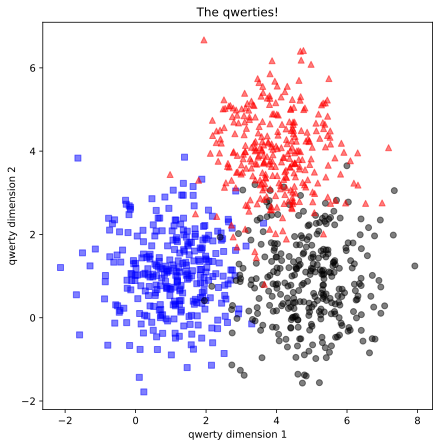

In [ ]:
n_per_clust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,4]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

labels_np = np.hstack((
    np.zeros((n_per_clust)),
    np.ones((n_per_clust)),
    1 + np.ones((n_per_clust))
))

data_np = np.hstack((
    a,b,c
)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize = (7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs', alpha = .5)
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha = .5)
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha = .5)

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')

plt.show()

# Train Test Split

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

In [ ]:
print(f'there are {len(train_dataloader)} batches, each with {batch_size} samples.')

there are 45 batches, each with 16 samples.


# Create and validate the model

In [ ]:
def createQwertyNet():

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(2, 8)

      self.fc1 = nn.Linear(8,8)

      self.output = nn.Linear(8,3)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      return self.output(x)

  net = qwertyNet()

  loss_fn = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)

  return net, loss_fn, optimizer

createQwertyNet()

(qwertyNet(
   (input): Linear(in_features=2, out_features=8, bias=True)
   (fc1): Linear(in_features=8, out_features=8, bias=True)
   (output): Linear(in_features=8, out_features=3, bias=True)
 ),
 CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [ ]:
net, loss_fn, optimizer = createQwertyNet()
temp_data = torch.randn(10, 2)
temp_y_hat = net(temp_data)
temp_y_hat

tensor([[ 0.2216,  0.2650,  0.0562],
        [ 0.1578,  0.3246, -0.1395],
        [ 0.1358,  0.3152, -0.0663],
        [ 0.1518,  0.2689, -0.0134],
        [ 0.0794,  0.3336, -0.1014],
        [ 0.1148,  0.3233, -0.0794],
        [ 0.2081,  0.2611,  0.0185],
        [ 0.0649,  0.3303, -0.1068],
        [ 0.1341,  0.3297, -0.1042],
        [ 0.1333,  0.3291, -0.1017]], grad_fn=<AddmmBackward0>)

# Train

In [ ]:
def ModelTrain():
  epochs = 100

  net, loss_fn, optimizer = createQwertyNet()

  losses = torch.zeros(epochs)
  train_acc = []
  test_acc = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc.append(np.mean(batch_acc))

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc.append(
        100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    )
  # end epochs

  return train_acc, test_acc, losses, net

# Run the Model and Plot the Results

In [ ]:
train_acc, test_acc, losses, net = ModelTrain()

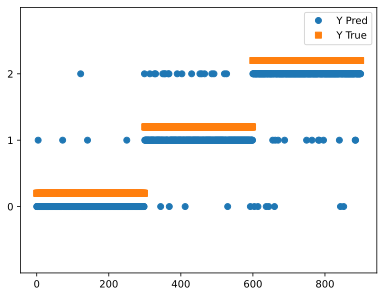

In [ ]:
y_hat = net(data)
preds = torch.argmax(y_hat, axis = 1)

plt.plot(preds, 'o', label = 'Y Pred')
plt.plot(labels + .2, 's', label = 'Y True')
plt.legend()
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.show()

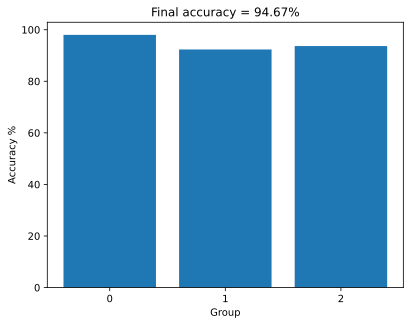

In [39]:
matches = (preds == labels).float()
total_acc = torch.mean(
    100 * matches
).item()

acc_by_group = torch.zeros(3)

for i in range(3):
  acc_by_group[i] = 100 * torch.mean(matches[labels == i])


plt.bar(range(3), acc_by_group)
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy %')
plt.title(f'Final accuracy = {total_acc:.2f}%')
plt.show()

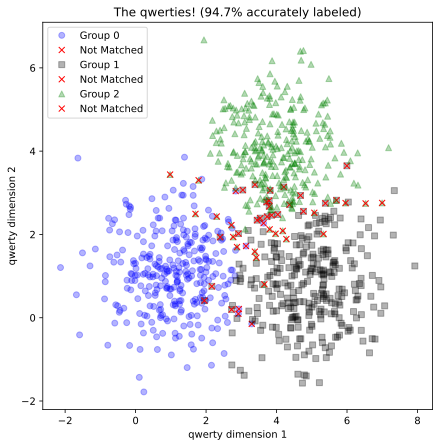

In [53]:
color_shape = ['bo', 'ks', 'g^']

fig = plt.figure(figsize = (7,7))

for i in range(3):
  plt.plot(data[labels == i, 0], data[labels == i, 1], color_shape[i], alpha = .3, label = f'Group {i}')

  error_idx = (matches == 0) & (labels == i)
  plt.plot(data[error_idx, 0], data[error_idx, 1], 'rx', label = 'Not Matched')

plt.title(f'The qwerties! ({total_acc:.1f}% accurately labeled)')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()